In [1]:
!pip install pandas -q
!pip install moexalgo -q
!pip install tsfresh -q
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.4 MB/s eta 0:00:00


# загрузка и настройка библиотек

In [2]:
import pandas as pd
from moexalgo import Ticker

from sklearn.model_selection import train_test_split

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings
from tsfresh.utilities.dataframe_functions import make_forecasting_frame

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats
import lightgbm as LGBMRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor,Pool
import matplotlib.pyplot as plt
import plotly.express as px

import pprint
pd.set_option("display.max_columns", 50)

# Функции

In [3]:
def compare_fact_forecast(y_train, y_train_pred, y_test, y_test_pred):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
  axes[0].scatter(y_test, y_test_pred, alpha=0.5)
  axes[0].set_title('Comparison fact with predict(Test)')
  axes[0].set_xlabel('fact')
  axes[0].set_ylabel('predict')

  axes[1].scatter(y_train, y_train_pred, alpha=0.5)
  axes[1].set_title('Comparison fact with predict (Train)')
  axes[1].set_xlabel('fact')
  axes[1].set_ylabel('predict')

  plt.tight_layout()
  plt.show()


In [4]:
def get_errors_hist(y_train, y_train_pred, y_test, y_test_pred):
  # Вычисляем остатки
  residuals_train = y_train - y_train_pred
  residuals_test = y_test - y_test_pred

  # Создаем гистограммы
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

  # Гистограмма остатков на тренировочных данных
  axes[0].hist(residuals_train, bins=50, color='blue', alpha=0.7)
  axes[0].set_title('Residuals Distribution (Train)')
  axes[0].set_xlabel('Residuals')
  axes[0].set_ylabel('Frequency')

  # Гистограмма остатков на тестовых данных
  axes[1].hist(residuals_test, bins=50, color='red', alpha=0.7)
  axes[1].set_title('Residuals Distribution (Test)')
  axes[1].set_xlabel('Residuals')
  axes[1].set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()


# Загрузим часть данных

In [5]:

fields_path = "https://drive.google.com/uc?export=download&id=13wf9SPj8se8qKDtW9-Ud94gzfry11mc-"


In [6]:
sec_fields = pd.read_csv(fields_path)
sec_fields.columns = [col.lower() for col in sec_fields.columns]
sec_fields.head()

,trade_code,bigfield
0,ABIO,Потребсектор
1,AFLT,транспорт
2,AGRO,Потребсектор
3,AKRN,Химпром
4,ALRS,Металлы и добыча


In [7]:
sec_fields.groupby('bigfield').groups.items()

dict_items([('ИТ', Int64Index([12, 26, 60, 65, 91, 95], dtype='int64')), ('Металлы и добыча', Int64Index([4, 11, 15, 25, 36, 48, 49, 55, 63, 64, 67, 73, 76, 92], dtype='int64')), ('Нефтегаз', Int64Index([7, 22, 33, 57, 69, 70, 79, 80, 83, 84, 88], dtype='int64')), ('Потребсектор', Int64Index([0, 2, 5, 6, 8, 19, 20, 23, 32, 37, 38, 51, 59, 82, 94], dtype='int64')), ('Строительные', Int64Index([16, 35, 62, 78], dtype='int64')), ('Телекоммуникации', Int64Index([39, 50, 71, 72, 89], dtype='int64')), ('Финансы', Int64Index([9, 10, 40, 66, 68, 74, 75, 77, 81, 85, 93], dtype='int64')), ('Химпром', Int64Index([3, 29, 30, 31, 53, 54, 61], dtype='int64')), ('Электроэнергетика', Int64Index([13, 14, 17, 27, 28, 34, 41, 42, 43, 44, 45, 46, 47, 58, 86, 87,
            90],
           dtype='int64')), ('транспорт', Int64Index([1, 18, 21, 24, 52, 56], dtype='int64'))])

In [8]:
df = pd.DataFrame()
for TRADE_CODE in sec_fields.head(5)['trade_code']:
  df_temp = pd.DataFrame(Ticker(TRADE_CODE).candles(date='2018-11-01', till_date='2023-12-31', period='D'))
  df_temp['trade_code'] = TRADE_CODE
  df = pd.concat([df, df_temp])


In [9]:
df.columns = [col.lower() for col in df.columns]

In [11]:
df.shape

(6352, 9)

In [10]:
df.groupby('trade_code').agg(count=('begin', 'count'))

,count
trade_code,
ABIO,1270
AFLT,1272
AGRO,1268
AKRN,1270
ALRS,1272


In [11]:
df[df['trade_code'] == 'ABIO'].head(20)

,open,close,high,low,value,volume,begin,end,trade_code
0,7.97,8.42,8.86,7.90,1027778.0,120100.0,2018-11-01,2018-11-01 23:59:59,ABIO
1,8.79,8.21,8.79,8.01,450546.0,55200.0,2018-11-02,2018-11-02 23:59:59,ABIO
2,8.15,8.18,8.18,7.96,242188.0,30000.0,2018-11-06,2018-11-06 23:59:59,ABIO
3,8.17,8.16,8.17,8.05,46825.0,5800.0,2018-11-07,2018-11-07 23:59:59,ABIO
4,8.08,8.17,8.17,8.08,8976.0,1100.0,2018-11-08,2018-11-08 23:59:59,ABIO
5,8.16,8.07,8.16,7.91,281684.0,35300.0,2018-11-09,2018-11-09 23:59:59,ABIO
6,7.95,8.07,8.10,7.94,94659.0,11900.0,2018-11-12,2018-11-12 23:59:59,ABIO
7,8.15,8.10,8.15,7.95,62916.0,7900.0,2018-11-13,2018-11-13 23:59:59,ABIO
8,8.07,8.10,8.10,8.07,20230.0,2500.0,2018-11-14,2018-11-14 23:59:59,ABIO
9,8.17,8.01,8.17,8.00,44901.0,5600.0,2018-11-15,2018-11-15 23:59:59,ABIO


# Преобразование типов

In [12]:
df['begin'] = pd.to_datetime(df['begin'])
df['end'] = pd.to_datetime(df['end'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6352 entries, 0 to 1271
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   open        6352 non-null   float64       
 1   close       6352 non-null   float64       
 2   high        6352 non-null   float64       
 3   low         6352 non-null   float64       
 4   value       6352 non-null   float64       
 5   volume      6352 non-null   float64       
 6   begin       6352 non-null   datetime64[ns]
 7   end         6352 non-null   datetime64[ns]
 8   trade_code  6352 non-null   object        
dtypes: datetime64[ns](2), float64(6), object(1)
memory usage: 496.2+ KB


# EDA

In [14]:
trade_code ='ABIO'
df_chart = df[df['trade_code'] == trade_code]

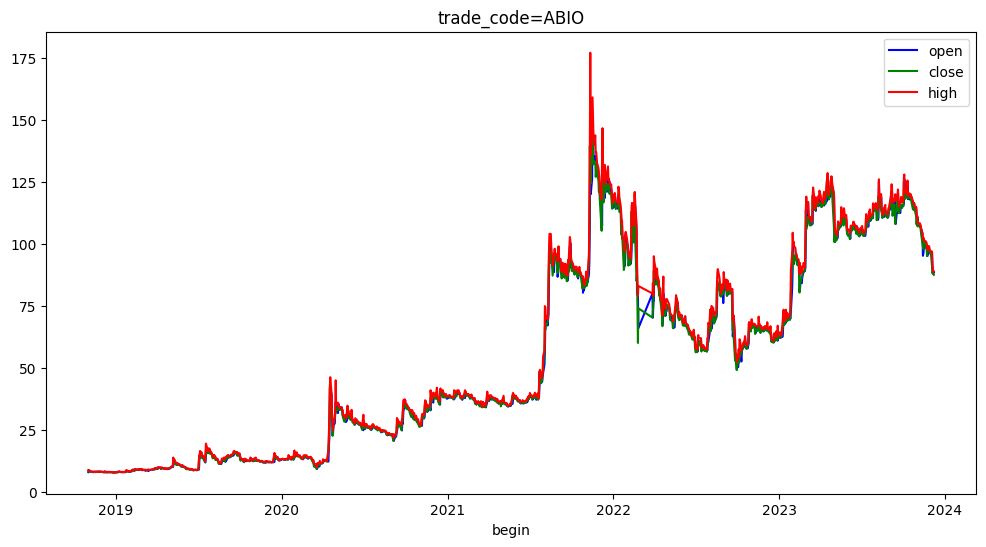

In [15]:
plt.figure(figsize=(12,6))
plt.plot(df_chart.begin, df_chart['open'], label='open', color='blue')
plt.plot(df_chart.begin, df_chart['close'], label='close', color='green')
plt.plot(df_chart.begin, df_chart['high'], label='high', color='red')

plt.title(f'trade_code={trade_code}')
plt.xlabel('begin')
# plt.ylabel('Значение')
plt.legend()
plt.show()


In [ ]:
# fig = px.line(df_chart, x='begin', y=['open', 'close', 'high'], title=f'trade_code={trade_code}',
#               )
# fig.show()

## лаги в истории

In [16]:
%%time
df_rolled = pd.DataFrame()
y_rolled = pd.DataFrame()
for trade_code in sec_fields.head(5)['trade_code']:
  print(f'trade_code={trade_code}')
  df_temp = df[df['trade_code'] == trade_code].copy()
  df_rolled_temp, y_rolled_temp = make_forecasting_frame(df_temp['open'],
                                                        kind='begin',
                                                        max_timeshift=None,
                                                        rolling_direction=1)
  df_rolled_temp['trade_code'] = trade_code
  y_rolled_temp = y_rolled_temp.reset_index()
  y_rolled_temp['trade_code'] = trade_code

  df_rolled = pd.concat([df_rolled, df_rolled_temp])
  y_rolled = pd.concat([y_rolled, y_rolled_temp])

trade_code=ABIO


Rolling: 100%|█████████▉| 1269/1270 [00:05<00:00, 291.30it/s]/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:350: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return [grouped_data.apply(_f)]
Rolling: 100%|██████████| 1270/1270 [00:05<00:00, 217.83it/s]


trade_code=AFLT


Rolling:  99%|█████████▉| 1265/1272 [00:04<00:00, 282.48it/s]/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:350: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return [grouped_data.apply(_f)]
Rolling: 100%|██████████| 1272/1272 [00:04<00:00, 290.46it/s]


trade_code=AGRO


Rolling:  99%|█████████▉| 1253/1268 [00:04<00:00, 195.87it/s]/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:350: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return [grouped_data.apply(_f)]
Rolling: 100%|██████████| 1268/1268 [00:04<00:00, 254.95it/s]


trade_code=AKRN


Rolling:  99%|█████████▊| 1251/1270 [00:03<00:00, 294.37it/s]/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:350: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return [grouped_data.apply(_f)]
Rolling: 100%|██████████| 1270/1270 [00:04<00:00, 312.54it/s]


trade_code=ALRS


Rolling:  99%|█████████▉| 1260/1272 [00:04<00:00, 285.59it/s]/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:350: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return [grouped_data.apply(_f)]
Rolling: 100%|██████████| 1272/1272 [00:04<00:00, 304.73it/s]


CPU times: user 29.6 s, sys: 1.26 s, total: 30.8 s
Wall time: 31.3 s


In [ ]:
# df[df['trade_code'] == 'AGRO']

In [17]:
df_rolled['id_new'] = df_rolled.apply(lambda x:
                                        str(x['id'][0])+'_'+str(x['id'][1])+'_'+x['trade_code'],
                                      axis=1)

In [18]:
y_rolled['id_new'] = y_rolled.apply(lambda x:
                                        str(x['index'][0])+'_'+str(x['index'][1])+'_'+x['trade_code'],
                                      axis=1)

In [19]:
df[(df['trade_code'] == 'AGRO')&(df['begin'] >= '2019-01-01')]

,open,close,high,low,value,volume,begin,end,trade_code
42,788.5,800.0,800.0,786.0,4272225.0,5385.0,2019-01-03,2019-01-03 23:59:59,AGRO
43,800.0,778.0,805.0,777.5,11126921.5,14130.0,2019-01-04,2019-01-04 23:59:59,AGRO
44,778.0,767.0,778.0,761.0,4332311.0,5656.0,2019-01-08,2019-01-08 23:59:59,AGRO
45,762.5,782.0,784.5,761.5,9167729.5,11841.0,2019-01-09,2019-01-09 23:59:59,AGRO
46,778.5,774.5,793.0,760.0,10649094.5,13721.0,2019-01-10,2019-01-10 23:59:59,AGRO
...,...,...,...,...,...,...,...,...,...
1263,1410.0,1375.2,1416.8,1362.8,367204019.4,264814.0,2023-12-04,2023-12-04 23:59:59,AGRO
1264,1371.0,1364.2,1394.0,1317.6,508510029.0,376669.0,2023-12-05,2023-12-05 23:59:59,AGRO
1265,1365.0,1351.8,1410.0,1331.0,584874206.0,424206.0,2023-12-06,2023-12-06 23:59:59,AGRO
1266,1347.6,1326.4,1374.4,1305.0,523521030.8,393318.0,2023-12-07,2023-12-07 23:59:59,AGRO


In [20]:
df_rolled[df_rolled['trade_code'] == 'AGRO']

,id,time,value,kind,trade_code,id_new
1,"(id, 1)",0,665.0,begin,AGRO,id_1_AGRO
3,"(id, 2)",0,665.0,begin,AGRO,id_2_AGRO
4,"(id, 2)",1,664.0,begin,AGRO,id_2_AGRO
6,"(id, 3)",0,665.0,begin,AGRO,id_3_AGRO
7,"(id, 3)",1,664.0,begin,AGRO,id_3_AGRO
...,...,...,...,...,...,...
804540,"(id, 1267)",1262,1449.2,begin,AGRO,id_1267_AGRO
804541,"(id, 1267)",1263,1410.0,begin,AGRO,id_1267_AGRO
804542,"(id, 1267)",1264,1371.0,begin,AGRO,id_1267_AGRO
804543,"(id, 1267)",1265,1365.0,begin,AGRO,id_1267_AGRO


In [21]:
df_rolled[df_rolled['trade_code'] == 'AGRO'].groupby('id_new', as_index=False).agg({'value':['min', 'max', 'mean']}).sort_values('id_new')

id_new  value                    
                      min     max        mean
0     id_1000_AGRO  448.8  1250.0  832.310500
1     id_1001_AGRO  448.8  1250.0  832.241059
2     id_1002_AGRO  448.8  1250.0  832.163972
3     id_1003_AGRO  448.8  1250.0  832.091027
4     id_1004_AGRO  448.8  1250.0  832.031375
...            ...    ...     ...         ...
1262   id_997_AGRO  448.8  1250.0  832.490371
1263   id_998_AGRO  448.8  1250.0  832.431563
1264   id_999_AGRO  448.8  1250.0  832.372873
1265    id_99_AGRO  664.0   842.0  771.924242
1266     id_9_AGRO  664.0   695.0  679.722222

[1267 rows x 4 columns]

In [ ]:
# y_rolled[y_rolled['trade_code'] == 'AGRO']

In [22]:
settings_minimal = settings.MinimalFCParameters()
settings_minimal

{'sum_values': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variance': None, 'root_mean_square': None, 'maximum': None, 'absolute_maximum': None, 'minimum': None}

In [23]:
cols = ['id_new', 'time', 'value']

df_features = extract_features(df_rolled[cols],
                               column_id="id_new",
                               column_sort="time",
                               default_fc_parameters=settings_minimal)
df_features

Feature Extraction: 100%|██████████| 6347/6347 [00:05<00:00, 1110.31it/s]


,value__sum_values,value__median,value__mean,value__length,value__standard_deviation,value__variance,value__root_mean_square,value__maximum,value__absolute_maximum,value__minimum
id_1000_ABIO,40927.59,33.785,40.927590,1000.0,32.730201,1.071266e+03,52.405474,152.03,152.03,7.79
id_1000_AFLT,74427.94,71.510,74.427940,1000.0,26.216933,6.873276e+02,78.910366,120.10,120.10,21.90
id_1000_AGRO,832310.50,794.600,832.310500,1000.0,167.597417,2.808889e+04,849.016880,1250.00,1250.00,448.80
id_1000_AKRN,7982938.00,5975.000,7982.938000,1000.0,4627.882304,2.141729e+07,9227.382821,28400.00,28400.00,4374.00
id_1000_ALRS,90957.79,87.620,90.957790,1000.0,23.038672,5.307804e+02,93.830166,151.00,151.00,53.50
...,...,...,...,...,...,...,...,...,...,...
id_9_ABIO,73.49,8.150,8.165556,9.0,0.233719,5.462469e-02,8.168900,8.79,8.79,7.95
id_9_AFLT,887.82,97.960,98.646667,9.0,2.023594,4.094933e+00,98.667420,102.00,102.00,95.92
id_9_AGRO,6117.50,680.000,679.722222,9.0,10.718911,1.148951e+02,679.806733,695.00,695.00,664.00
id_9_AKRN,41062.00,4554.000,4562.444444,9.0,32.163164,1.034469e+03,4562.557811,4634.00,4634.00,4520.00


In [24]:
sample = df_features.reset_index().rename(columns={'index':'id_new'})\
                    .merge(y_rolled[['id_new', 'value', 'trade_code']], on='id_new')

In [25]:
sample.head()

,id_new,value__sum_values,value__median,value__mean,value__length,value__standard_deviation,value__variance,value__root_mean_square,value__maximum,value__absolute_maximum,value__minimum,value,trade_code
0,id_1000_ABIO,40927.59,33.785,40.92759,1000.0,32.730201,1.071266e+03,52.405474,152.03,152.03,7.79,67.10,ABIO
1,id_1000_AFLT,74427.94,71.510,74.42794,1000.0,26.216933,6.873276e+02,78.910366,120.10,120.10,21.90,24.72,AFLT
2,id_1000_AGRO,832310.50,794.600,832.31050,1000.0,167.597417,2.808889e+04,849.016880,1250.00,1250.00,448.80,762.80,AGRO
3,id_1000_AKRN,7982938.00,5975.000,7982.93800,1000.0,4627.882304,2.141729e+07,9227.382821,28400.00,28400.00,4374.00,17926.00,AKRN
4,id_1000_ALRS,90957.79,87.620,90.95779,1000.0,23.038672,5.307804e+02,93.830166,151.00,151.00,53.50,66.96,ALRS


In [26]:
sample = sample.merge(sec_fields, on='trade_code')

In [27]:
sample.shape

(6347, 14)

In [28]:
df.shape

(6352, 9)

In [29]:
sample.head()

,id_new,value__sum_values,value__median,value__mean,value__length,value__standard_deviation,value__variance,value__root_mean_square,value__maximum,value__absolute_maximum,value__minimum,value,trade_code,bigfield
0,id_1000_ABIO,40927.59,33.785,40.927590,1000.0,32.730201,1071.266084,52.405474,152.03,152.03,7.79,67.10,ABIO,Потребсектор
1,id_1001_ABIO,40994.69,33.800,40.953736,1001.0,32.724295,1070.879515,52.422209,152.03,152.03,7.79,66.72,ABIO,Потребсектор
2,id_1002_ABIO,41061.41,33.800,40.979451,1002.0,32.718079,1070.472687,52.438422,152.03,152.03,7.79,65.20,ABIO,Потребсектор
3,id_1003_ABIO,41126.61,33.800,41.003599,1003.0,32.710697,1069.989714,52.452692,152.03,152.03,7.79,65.44,ABIO,Потребсектор
4,id_1004_ABIO,41192.05,33.825,41.027938,1004.0,32.703488,1069.518153,52.467227,152.03,152.03,7.79,65.78,ABIO,Потребсектор


In [30]:
sample.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id_new,6347,6347,id_1000_ABIO,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
value__sum_values,6347.0,NaN,NaN,NaN,1031051.658629,2411368.795694,7.97,31543.505,74427.94,660013.55,13047526.0
value__median,6347.0,NaN,NaN,NaN,1247.415915,2057.186628,7.97,72.43,98.4,770.5,6100.0
value__mean,6347.0,NaN,NaN,NaN,1430.881667,2521.659502,7.97,76.818377,96.20679,825.108098,10281.738377
value__length,6347.0,NaN,NaN,NaN,635.200882,366.474501,1.0,318.0,635.0,952.5,1271.0
value__standard_deviation,6347.0,NaN,NaN,NaN,427.444409,1248.244033,0.0,12.735663,28.174226,133.634393,6048.113101
value__variance,6347.0,NaN,NaN,NaN,1740576.399582,6565103.000998,0.0,162.197105,793.786999,17858.151946,36579672.076549
value__root_mean_square,6347.0,NaN,NaN,NaN,1529.205715,2794.373577,7.97,80.615032,97.374582,842.135718,11928.697168
value__maximum,6347.0,NaN,NaN,NaN,3085.359445,7230.041442,7.97,114.38,151.0,1250.0,28400.0
value__absolute_maximum,6347.0,NaN,NaN,NaN,3085.359445,7230.041442,7.97,114.38,151.0,1250.0,28400.0


In [31]:
sample.isna().mean().sort_values()

id_new                       0.0
value__sum_values            0.0
value__median                0.0
value__mean                  0.0
value__length                0.0
value__standard_deviation    0.0
value__variance              0.0
value__root_mean_square      0.0
value__maximum               0.0
value__absolute_maximum      0.0
value__minimum               0.0
value                        0.0
trade_code                   0.0
bigfield                     0.0
dtype: float64

# Делим на трейн и тест

In [32]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
sample['bigfield_enc'] = enc.fit_transform(sample['bigfield'])




In [33]:
X_train, X_test, y_train, y_test = train_test_split(sample.drop(columns='value'),
                                                    sample['value'],
                                                    test_size=.7,
                                                    # stratify=sample['trade_code'],
                                                    shuffle = False,
                                                    random_state = 12345)


In [34]:
sample

,id_new,value__sum_values,value__median,value__mean,value__length,value__standard_deviation,value__variance,value__root_mean_square,value__maximum,value__absolute_maximum,value__minimum,value,trade_code,bigfield,bigfield_enc
0,id_1000_ABIO,40927.59,33.785,40.927590,1000.0,32.730201,1071.266084,52.405474,152.03,152.03,7.79,67.10,ABIO,Потребсектор,1
1,id_1001_ABIO,40994.69,33.800,40.953736,1001.0,32.724295,1070.879515,52.422209,152.03,152.03,7.79,66.72,ABIO,Потребсектор,1
2,id_1002_ABIO,41061.41,33.800,40.979451,1002.0,32.718079,1070.472687,52.438422,152.03,152.03,7.79,65.20,ABIO,Потребсектор,1
3,id_1003_ABIO,41126.61,33.800,41.003599,1003.0,32.710697,1069.989714,52.452692,152.03,152.03,7.79,65.44,ABIO,Потребсектор,1
4,id_1004_ABIO,41192.05,33.825,41.027938,1004.0,32.703488,1069.518153,52.467227,152.03,152.03,7.79,65.78,ABIO,Потребсектор,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6342,id_997_ALRS,90753.29,87.690,91.026369,997.0,23.039283,530.808581,93.896797,151.00,151.00,53.50,67.25,ALRS,Металлы и добыча,0
6343,id_998_ALRS,90820.54,87.690,91.002545,998.0,23.040021,530.842590,93.873882,151.00,151.00,53.50,68.60,ALRS,Металлы и добыча,0
6344,id_999_ALRS,90889.14,87.690,90.980120,999.0,23.039381,530.813090,93.851986,151.00,151.00,53.50,68.65,ALRS,Металлы и добыча,0
6345,id_99_ALRS,9775.15,98.700,98.738889,99.0,2.859283,8.175499,98.780280,104.27,104.27,92.52,94.51,ALRS,Металлы и добыча,0


In [35]:
y_train

0       67.10
1       66.72
2       65.20
3       65.44
4       65.78
        ...  
1899    81.00
1900    81.80
1901    82.44
1902    82.08
1903    83.26
Name: value, Length: 1904, dtype: float64

In [36]:
X_train_copy=X_train.copy()
X_test_copy=X_test.copy()

## Rolling на первоначальных данных

In [ ]:
# plt.figure(figsize=(12,6))
# plt.plot(df_chart.begin, df_chart['open'], label='open', color='blue')
# plt.plot(df_chart.begin, df_chart['close'], label='close', color='green')
# plt.plot(df_chart.begin, df_chart['high'], label='high', color='red')

# plt.title(f'trade_code={trade_code}')
# plt.xlabel('begin')
# # plt.ylabel('Значение')
# plt.legend()
# plt.show()


In [37]:
n = 3
col = 'open'
df[f'{col}_{n}'] = df.groupby(['trade_code'])[col].shift(n)


In [38]:
# задаем размер окна для rolling-среднего
window_size = 3
df[f'{col}_rolling_mean_{window_size}'] = df.groupby(['trade_code'])[col]\
                                                          .rolling(window=window_size,
                                                                   min_periods=1)\
                                                          .mean()\
                                                          .reset_index()[col]


In [39]:
df_chart = df[df['trade_code'] == 'ABIO']\
              .reset_index()\
              .sort_values('index')

In [40]:
df_chart.head()

,index,open,close,high,low,value,volume,begin,end,trade_code,open_3,open_rolling_mean_3
0,0,7.97,8.42,8.86,7.90,1027778.0,120100.0,2018-11-01,2018-11-01 23:59:59,ABIO,NaN,7.970000
1,1,8.79,8.21,8.79,8.01,450546.0,55200.0,2018-11-02,2018-11-02 23:59:59,ABIO,NaN,8.380000
2,2,8.15,8.18,8.18,7.96,242188.0,30000.0,2018-11-06,2018-11-06 23:59:59,ABIO,NaN,8.303333
3,3,8.17,8.16,8.17,8.05,46825.0,5800.0,2018-11-07,2018-11-07 23:59:59,ABIO,7.97,8.370000
4,4,8.08,8.17,8.17,8.08,8976.0,1100.0,2018-11-08,2018-11-08 23:59:59,ABIO,8.79,8.133333


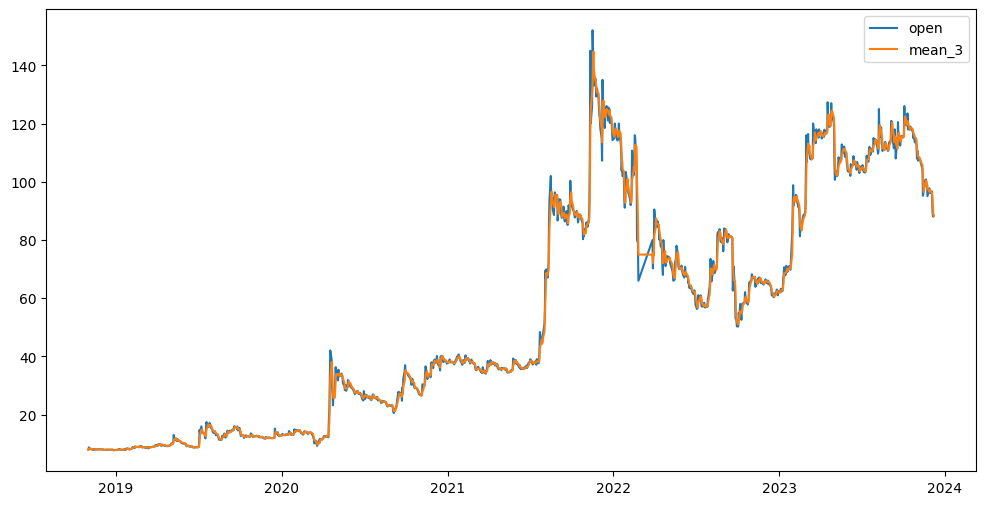

In [41]:
plt.figure(figsize=(12,6))

plt.plot(df_chart['begin'],
            df_chart['open'], label='open')

plt.plot(df_chart['begin'],
            df_chart['open_rolling_mean_3'], label='mean_3')
plt.legend()

In [42]:
df_chart

,index,open,close,high,low,value,volume,begin,end,trade_code,open_3,open_rolling_mean_3
0,0,7.97,8.42,8.86,7.90,1027778.0,120100.0,2018-11-01,2018-11-01 23:59:59,ABIO,NaN,7.970000
1,1,8.79,8.21,8.79,8.01,450546.0,55200.0,2018-11-02,2018-11-02 23:59:59,ABIO,NaN,8.380000
2,2,8.15,8.18,8.18,7.96,242188.0,30000.0,2018-11-06,2018-11-06 23:59:59,ABIO,NaN,8.303333
3,3,8.17,8.16,8.17,8.05,46825.0,5800.0,2018-11-07,2018-11-07 23:59:59,ABIO,7.97,8.370000
4,4,8.08,8.17,8.17,8.08,8976.0,1100.0,2018-11-08,2018-11-08 23:59:59,ABIO,8.79,8.133333
...,...,...,...,...,...,...,...,...,...,...,...,...
1265,1265,96.70,91.00,96.90,90.00,41272408.4,447130.0,2023-12-04,2023-12-04 23:59:59,ABIO,97.36,96.306667
1266,1266,90.00,88.10,91.48,86.32,29733281.4,335480.0,2023-12-05,2023-12-05 23:59:59,ABIO,96.12,94.266667
1267,1267,88.14,88.78,89.78,86.32,19141083.8,218170.0,2023-12-06,2023-12-06 23:59:59,ABIO,96.10,91.613333
1268,1268,88.04,87.80,88.66,85.50,15839572.6,182410.0,2023-12-07,2023-12-07 23:59:59,ABIO,96.70,88.726667


In [43]:
# задаем размер окна для rolling-среднего
# window_size = 3
# rol_train[f'{col}_rolling_mean'] = rol_train.groupby(['trade_code'])[col].rolling(window=window_size,
#                                                                               min_periods=1).mean().reset_index()[col]


NameError: ignored

# Обучаем модели

## KNN

In [44]:
X_train=X_train.drop(columns=['id_new', 'trade_code', 'bigfield'])
X_test=X_test.drop(columns=['id_new', 'trade_code', 'bigfield'])

In [47]:
X_train

,value__sum_values,value__median,value__mean,value__length,value__standard_deviation,value__variance,value__root_mean_square,value__maximum,value__absolute_maximum,value__minimum,bigfield_enc
0,40927.59,33.785,40.927590,1000.0,32.730201,1071.266084,52.405474,152.03,152.03,7.79,1
1,40994.69,33.800,40.953736,1001.0,32.724295,1070.879515,52.422209,152.03,152.03,7.79,1
2,41061.41,33.800,40.979451,1002.0,32.718079,1070.472687,52.438422,152.03,152.03,7.79,1
3,41126.61,33.800,41.003599,1003.0,32.710697,1069.989714,52.452692,152.03,152.03,7.79,1
4,41192.05,33.825,41.027938,1004.0,32.703488,1069.518153,52.467227,152.03,152.03,7.79,1
...,...,...,...,...,...,...,...,...,...,...,...
1899,41411.88,101.600,97.900426,423.0,12.552382,157.562287,98.701852,120.10,120.10,55.84,3
1900,41492.88,101.600,97.860566,424.0,12.564344,157.862732,98.663839,120.10,120.10,55.84,3
1901,41574.68,101.600,97.822776,425.0,12.573654,158.096784,98.627544,120.10,120.10,55.84,3
1902,41657.12,101.600,97.786667,426.0,12.580931,158.279830,98.592657,120.10,120.10,55.84,3


In [48]:
k = 8

knn = KNeighborsRegressor(n_neighbors=k)

# Обучение
knn_model = knn.fit(X_train, y_train)


In [49]:
pred_test = knn.predict(X_test)
pred_train = knn.predict(X_train)


In [50]:
rmse_train = mean_squared_error(y_train,pred_train, squared=False)
mae_train = mean_absolute_error(y_train,pred_train)

In [51]:
rmse_test = mean_squared_error(y_test, pred_test, squared=False)
mae_test = mean_absolute_error(y_test,pred_test)

In [52]:
y_train.mean(), y_test.mean()

(59.382631302521006, 3218.5463493135267)

In [53]:
rmse_train,rmse_test

(4.955563885991653, 6380.253975020056)

In [54]:
mae_train,mae_test

(1.6637047006302523, 3177.1867614787307)

## LinearRegression

In [55]:
linear_reg= LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

In [56]:

lin_pred_test = linear_reg.predict(X_test)
lin_pred_train = linear_reg.predict(X_train)


In [57]:
rmse_train = mean_squared_error(y_train,lin_pred_train, squared=False)
mae_train = mean_absolute_error(y_train,lin_pred_train)

In [58]:
rmse_test = mean_squared_error(y_test, lin_pred_test, squared=False)
mae_test = mean_absolute_error(y_test,lin_pred_test)

In [59]:
rmse_train,rmse_test

(12.664070719795179, 478124.0940207789)

In [60]:
mae_train,mae_test

(8.790723865974416, 145636.63069473943)

## DecisionTree

In [61]:
decision_tree = DecisionTreeRegressor(max_depth=12, min_samples_split=7)

# Обучение
decision_tree = decision_tree.fit(X_train, y_train)
tr_pred_test = decision_tree.predict(X_test)
tr_pred_train= decision_tree.predict(X_train)

In [62]:
rmse_train = mean_squared_error(y_train,tr_pred_train, squared=False)
mae_train = mean_absolute_error(y_train,tr_pred_train)

In [63]:
rmse_test = mean_squared_error(y_test, tr_pred_test, squared=False)
mae_test = mean_absolute_error(y_test,tr_pred_test)

In [64]:
y_train.mean(), y_test.mean()

(59.382631302521006, 3218.5463493135267)

In [65]:
rmse_train,rmse_test

(1.0925714146492544, 6384.716973214027)

In [66]:
mae_train,mae_test

(0.6014456140172912, 3180.1976630547783)

## ML models

## LGBM

In [67]:
b_lgbm = lgb.LGBMRegressor()

# Обучение
b_lgbm.fit(X_train, y_train)
lgbm_pred_test = b_lgbm.predict(X_test)
lgbm_pred_train = b_lgbm.predict(X_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1860
[LightGBM] [Info] Number of data points in the train set: 1904, number of used features: 11
[LightGBM] [Info] Start training from score 59.382631


In [68]:
rmse_train = mean_squared_error(y_train,lgbm_pred_train, squared=False)
mae_train = mean_absolute_error(y_train,lgbm_pred_train)

In [69]:
rmse_test = mean_squared_error(y_test, lgbm_pred_test, squared=False)
mae_test = mean_absolute_error(y_test,lgbm_pred_test)

In [70]:
y_train.mean(), y_test.mean()

(59.382631302521006, 3218.5463493135267)

In [71]:
rmse_train,rmse_test

(1.9902122291518778, 6382.779297854052)

In [72]:
mae_train,mae_test

(1.0697198471241354, 3177.726627282202)

## RFR

In [73]:
X_train.shape


RFC = RandomForestRegressor(n_estimators=37, random_state=241)
RFC.fit(X_train, y_train)

RandomForestRegressor(max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=37, n_jobs=None,
            oob_score=False, random_state=241, verbose=0, warm_start=False)

predicted = RFC.predict(X_test)

In [74]:
rf_pred_train = RFC.predict(X_train)

In [75]:
rmse_train = mean_squared_error(y_train,rf_pred_train, squared=False)
mae_train = mean_absolute_error(y_train,rf_pred_train)

In [76]:
rmse_test = mean_squared_error(y_test, predicted, squared=False)
mae_test = mean_absolute_error(y_test,predicted)

In [77]:
y_train.mean(), y_test.mean()

(59.382631302521006, 3218.5463493135267)

In [78]:
rmse_train,rmse_test

(0.8623268417131129, 6383.075163138001)

In [79]:
mae_train,mae_test

(0.4139187769702478, 3177.6441889762823)

In [82]:
# Определите категориальные признаки
categorical_features = [ 'bigfield_enc', ]

# Инициализируйте Pool для тренировочных данных
train_pool = Pool(X_train, label=y_train, cat_features=categorical_features)

# Инициализируйте Pool для тестовых данных
test_pool = Pool(X_test, label=y_test, cat_features=categorical_features)


In [83]:
params = {'iterations':500,
          'learning_rate':0.1,
          'depth':5,
          'loss_function':'RMSE',
          'random_seed':42}

In [84]:
import xgboost as xgb

In [85]:
model_cat = CatBoostRegressor(**params)

In [86]:
_ = model_cat.fit(train_pool, silent=True)

In [87]:
pred_train = model_cat.predict(train_pool)
pred_test = model_cat.predict(test_pool)

In [88]:
rmse_train = mean_squared_error(y_train,pred_train, squared=False)
mae_train = mean_absolute_error(y_train,pred_train)

In [89]:
rmse_test = mean_squared_error(y_test, pred_test, squared=False)
mae_test = mean_absolute_error(y_test,pred_test)

In [90]:
y_train.mean(), y_test.mean()

(59.382631302521006, 3218.5463493135267)

In [91]:
rmse_train,rmse_test

(1.899553619042856, 6370.005137711934)

In [92]:
mae_train,mae_test

(1.1880747021586986, 3160.756073917382)

# Анализ ошибок

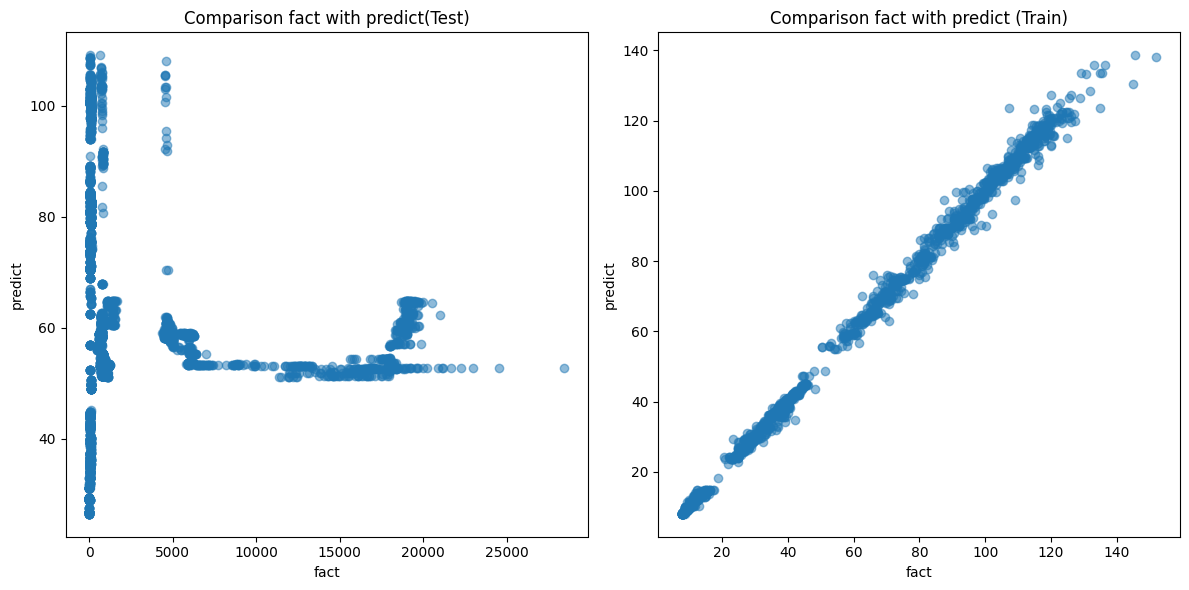

In [93]:
compare_fact_forecast(y_train, pred_train, y_test, pred_test)

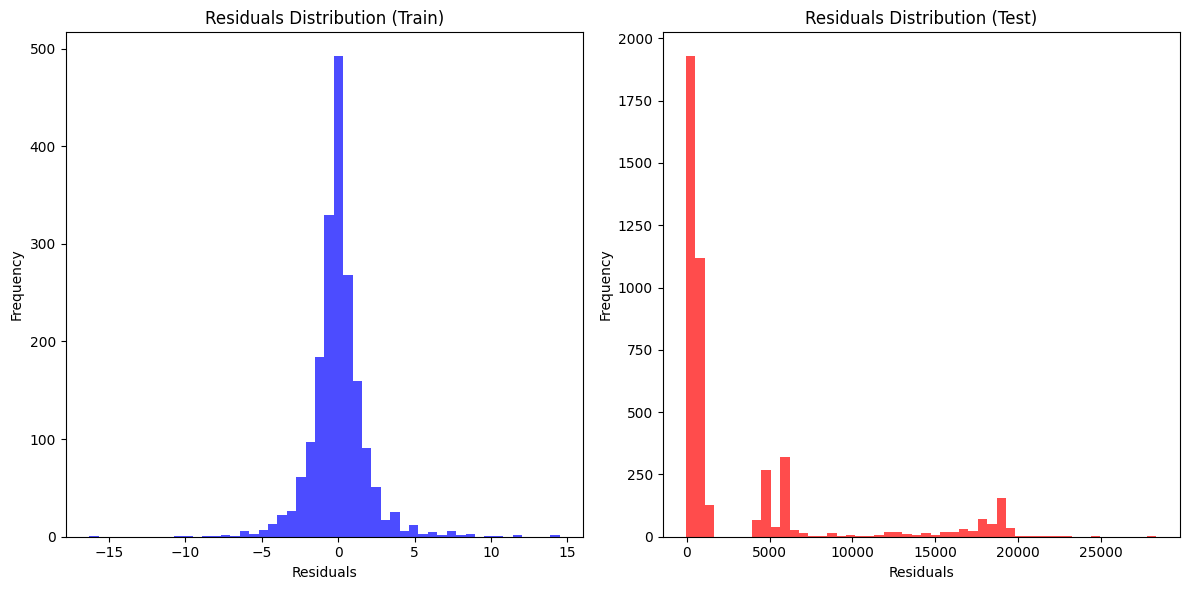

In [94]:
get_errors_hist(y_train, pred_train, y_test, pred_test)


# Вывод
Алгоритмы показали слишком большую ошибку на тесте, в построении решения, их не используем